In [12]:
import os
os.chdir('/data/alimama/code')
import numpy as np
import pandas as pd
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

FRAC = 0.25

In [1]:
!python3 -V

Python 3.5.2


In [5]:
user = pd.read_csv('../raw_data/user_profile.csv')
sample = pd.read_csv('../raw_data/raw_sample.csv')

if not os.path.exists('../sampled_data/'):
    os.mkdir('../sampled_data/')

if os.path.exists('../sampled_data/user_profile_' + str(FRAC) + '_.pkl') and os.path.exists(
        '../sampled_data/raw_sample_' + str(FRAC) + '_.pkl'):
    user_sub = pd.read_pickle(
        '../sampled_data/user_profile_' + str(FRAC) + '_.pkl')
    sample_sub = pd.read_pickle(
        '../sampled_data/raw_sample_' + str(FRAC) + '_.pkl')
else:
    if FRAC < 1.0:
        user_sub = user.sample(frac=FRAC, random_state=1024)
    else:
        user_sub = user
    sample_sub = sample.loc[sample.user.isin(user_sub.userid.unique())]
    pd.to_pickle(user_sub, '../sampled_data/user_profile_' +
                 str(FRAC) + '.pkl')
    pd.to_pickle(sample_sub, '../sampled_data/raw_sample_' +
                 str(FRAC) + '.pkl')

In [8]:
ad = pd.read_csv('../raw_data/ad_feature.csv')
pd.to_pickle(ad, '../sampled_data/ad_feature_enc_' + str(FRAC) + '.pkl')

In [16]:
user = user.fillna(-1)
user.rename(
    columns={'new_user_class_level ': 'new_user_class_level'}, inplace=True)

# sample_sub = pd.read_pickle(
#     '../sampled_data/raw_sample_' + str(FRAC) + '.pkl')
sample_sub.rename(columns={'user': 'userid'}, inplace=True)

data = pd.merge(sample_sub, user, how='left', on='userid', )
data = pd.merge(data, ad, how='left', on='adgroup_id')

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [23]:
sparse_features = ['userid', 'adgroup_id', 'pid', 'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level',
                       'pvalue_level', 'shopping_level', 'occupation', 'new_user_class_level', 'campaign_id',
                       'customer', 'cate_id', 'brand'] # 15 sparse features
for feat in tqdm(sparse_features):
    lbe = LabelEncoder()  # or Hash
    data[feat] = lbe.fit_transform(data[feat])

100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


In [26]:
pd.to_pickle(data, '../sampled_data/data_' +
                 str(FRAC) + '.pkl')

In [45]:
customer_dic, cate_dic, ad_dic = {}, {}, {}

for name, group in data.groupby('cate_id'):
    clk_n = group[group.clk==1].shape[0]
    cate_dic[name] = clk_n
    
for name, group in data.groupby('customer'):
    clk_n = group[group.clk==1].shape[0]
    customer_dic[name] = clk_n
    
for name, group in data.groupby('adgroup_id'):
    clk_n = group[group.clk==1].shape[0]
    ad_dic[name] = clk_n
    
data['label_ad'] = data['adgroup_id'].apply(lambda x: ad_dic[x])
data['label_cate'] = data['cate_id'].apply(lambda x: cate_dic[x])
data['label_customer'] = data['customer'].apply(lambda x: customer_dic[x])

In [118]:
pd.to_pickle(data, '../sampled_data/data_mtl_v1_' +
                 str(FRAC) + '.pkl')

In [114]:
suma = 0
for value in ad_dic.values():
    if value ==0:
        suma+=1
print(suma)

401618


In [117]:
suma/(data['adgroup_id'].max()+1)

0.7837503976145082

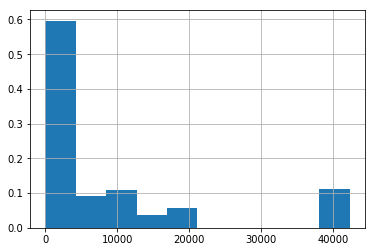

In [76]:
plt = data['label_cate'].hist(weights = np.ones_like(data.index) / len(data.index))

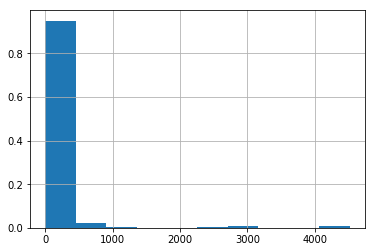

In [77]:
plt = data['label_customer'].hist(weights = np.ones_like(data.index) / len(data.index))

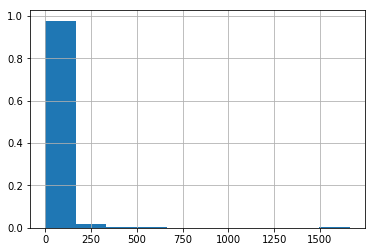

In [97]:
plt = data['label_ad'].hist(weights = np.ones_like(data.index) / len(data.index))

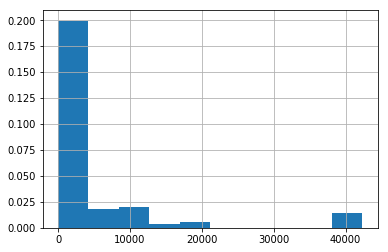

In [106]:
test = data[(data.label_ad==0) & (data.label_cate>0)]
plt = test['label_cate'].hist(weights = np.ones_like(test.index) / len(data.index))

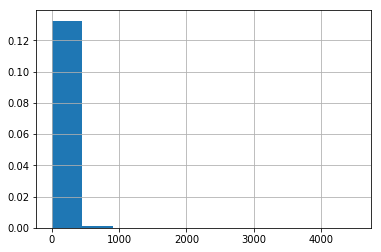

In [107]:
test = data[(data.label_ad==0) & (data.label_customer>0)]
plt = test['label_customer'].hist(weights = np.ones_like(test.index) / len(data.index))

In [112]:
data.loc[data['label_customer']==0].shape[0]

809958

In [96]:
data

,userid,time_stamp,adgroup_id,pid,nonclk,clk,cms_segid,cms_group_id,final_gender_code,age_level,...,occupation,new_user_class_level,cate_id,campaign_id,customer,brand,price,label_cate,label_customer,label_ad
0,171978,1494115387,3,0,1,0,0,4,1,4,...,0,1,1740,281917,19321,21329,176.0,175,0,0
1,58245,1494281673,4,0,1,0,20,3,1,3,...,0,3,3088,97655,4868,17782,289.0,367,0,0
2,130268,1494545239,4,0,1,0,0,3,1,3,...,0,0,3088,97655,4868,17782,289.0,367,0,0
3,89115,1494475741,4,0,1,0,20,3,1,3,...,0,4,3088,97655,4868,17782,289.0,367,0,0
4,58245,1494540717,4,0,1,0,20,3,1,3,...,0,3,3088,97655,4868,17782,289.0,367,0,0
5,161783,1494555943,15,1,1,0,0,9,0,3,...,0,4,1917,291650,40136,178,20.0,1409,2,0
6,6041,1494478631,16,0,1,0,0,9,0,3,...,0,2,1343,288820,3910,66259,1800.0,55,0,0
7,85526,1494248485,16,0,1,0,0,4,1,4,...,0,1,1343,288820,3910,66259,1800.0,55,0,0
8,219075,1494381318,16,1,1,0,0,11,0,5,...,0,0,1343,288820,3910,66259,1800.0,55,0,0
9,45940,1494047474,22,0,1,0,0,3,1,3,...,0,0,1917,291650,40136,178,1.6,1409,2,0
